In [1]:
import datetime

from sqlmodel import SQLModel, Session, create_engine

from matched.db.tables import Rego, Ro
from matched.db.utils import bulk_upsert_records, read_table
from matched.definitions.renewableandchpregister import CertificatesFilter
from matched.connectors.renewableandchpregister import get_certificates_by_date_range, extract_rego_roc_dfs

In [2]:
engine = create_engine(f"sqlite:///../data/matched.db")

with Session(engine) as session:
    SQLModel.metadata.create_all(engine, tables=[Rego.__table__, Ro.__table__])

In [3]:
download_data = True

if download_data:
    certificates_filter = CertificatesFilter()  # additional filter params can be specified here
    df = get_certificates_by_date_range(datetime.datetime(2006, 3, 1), datetime.datetime(2024, 5, 1), certificates_filter=certificates_filter)

    df_rego_records, df_ro_records = df.query('status_date>"2018-01-01"').pipe(extract_rego_roc_dfs)

    with Session(engine) as session:
        bulk_upsert_records(session, df_rego_records.drop_duplicates(), Rego)
        bulk_upsert_records(session, df_ro_records.drop_duplicates(), Ro)

with Session(engine) as session:
    df_rego = read_table(session, Rego)
    df_ro = read_table(session, Ro)

df_ro

,delivery_start,no_of_certificates,certificate_type,delivery_end,start_certificate_no,current_holder_organisation_name,end_certificate_no,generating_station_agent_group,mwh_per_certificate,station_tic,...,end_certificate_idx,country,certificate_status,status_date,technology_group,company_registration_number,start_certificate_idx,accreditation_no,output_period,generation_type
0,2007-01-01,623,XXX,2007-01-31,R00008RJEN0000000107XXX,Infinis Limited,R00008RJEN0006220107XXX,Judkins/Tuttle Hill Landfill,1.000000,1150.0,...,623,England,Retired,2018-07-11,Landfill Gas,None,1,R00008RJEN,Jan-2007,None
1,2008-04-01,213,XXX,2008-04-30,R00213RJEN0001580408XXX,Infinis Limited,R00213RJEN0003700408XXX,CALVERT PHASE II,1.000000,30611.0,...,371,England,Retired,2018-07-11,Landfill Gas,None,159,R00213RJEN,Apr-2008,None
2,2008-04-01,12,XXX,2008-04-30,R00001NYNI0000000408XXX,Kildress Hydro,R00001NYNI0000110408XXX,Kildress Hydro - M,1.000000,30.0,...,12,Northern Ireland,Retired,2022-03-15,Hydro 50kW DNC or less,None,1,R00001NYNI,Apr-2008,None
3,2009-02-01,497,XXX,2009-02-28,R00635RJEN0000000209XXX,Infinis (Re-Gen) Limited,R00635RJEN0004960209XXX,"Candles Coalmoor Landfill - A,C",1.000000,1003.0,...,497,England,Retired,2018-07-11,Landfill Gas,None,1,R00635RJEN,Feb-2009,None
4,2009-02-01,69,XXX,2009-02-28,R00143RJEN0003650209XXX,ENGIE POWER LIMITED,R00143RJEN0004330209XXX,WANGFORD LANDFILL SITE,1.000000,200.0,...,434,England,Retired,2018-08-31,Landfill Gas,None,366,R00143RJEN,Feb-2009,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326426,2021-04-01,15,PVG,2021-04-30,R08146NGNI1722550421PVG,OFGEM Power NI Holding Account,R08146NGNI1722690421PVG,Agent_Power NI Energy Limited_NIRO_Photovoltai...,0.250000,0.0,...,172270,Northern Ireland,Issued,2023-08-11,Photovoltaic 50kW DNC or less,NI27394,172256,R08146NGNI,2021 - 2022,None
326427,2021-04-01,41,PVV,2021-04-30,R11893NGNI0066600421PVV,Garganey Sustainable Energy Solutions Limited,R11893NGNI0067000421PVV,Annual_Garganey Sustainable Energy Solutions L...,0.250000,0.0,...,6701,Northern Ireland,Issued,2023-08-16,Photovoltaic 50kW DNC or less,08993344,6661,R11893NGNI,2021 - 2022,None
326428,2021-04-01,3,PVG,2021-04-30,R08146NGNI1722990421PVG,Power NI Energy Ltd,R08146NGNI1723010421PVG,Agent_Power NI Energy Limited_NIRO_Photovoltai...,0.250000,0.0,...,172302,Northern Ireland,Revoked,2023-08-30,Photovoltaic 50kW DNC or less,None,172300,R08146NGNI,2021 - 2022,None
326429,2021-04-01,112,GSK,2021-04-30,R00090SASC0000000421GSK,A F Scott And Company (Hoteliers) Limited,R00090SASC0001110421GSK,Angus Hotel CHP_Extension,0.555556,245.0,...,112,Scotland,Revoked,2023-08-30,Fuelled,SC062684,1,R00090SASC,Apr-2021,Standard gasification


<Axes: xlabel='delivery_start'>

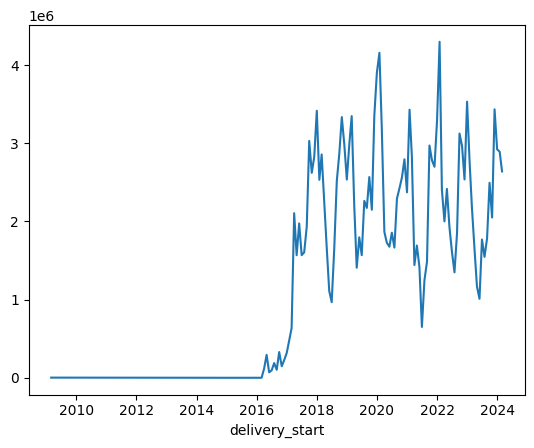

In [4]:
df_technology = df_ro.query('technology_group=="On-shore Wind"')
df_technology = df_technology.assign(mwh=df_technology['no_of_certificates'].multiply(df_technology['mwh_per_certificate']))
df_technology_output = df_technology.groupby('delivery_start')['mwh'].sum()

df_technology_output.plot()

<Axes: xlabel='delivery_start'>

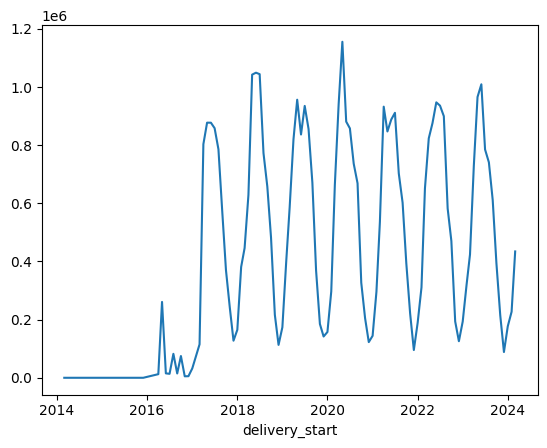

In [5]:
df_technology = df_ro.query('technology_group=="Photovoltaic "')
df_technology = df_technology.assign(mwh=df_technology['no_of_certificates'].multiply(df_technology['mwh_per_certificate']))
df_technology_output = df_technology.groupby('delivery_start')['mwh'].sum()

df_technology_output.plot()